In [1]:
import pandas as pd
import numpy as np


from coactivation.process import preprocess_emgs, get_coactivation_map, emgs, mirror_left_right_emgs
from coactivation.visualize import visualize_emgs, plot_coactivation_map, plot_one_class_coactivation_map

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy.spatial.distance import cdist, jensenshannon, pdist
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap

# 2. new dataset exploration


In [2]:
df = pd.read_csv('coactivations_by_gt.csv', index_col=0)
df

,window,gt,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7,hand,is_patient,subject_id,date,n
0,0,0,0.112426,0.151724,0.094421,0.033537,0.020488,0.034722,0.032702,0.076923,left,False,fa,2023_10_16,11
1,1,1,0.147929,0.200000,0.154506,0.112805,0.195122,0.333333,0.125645,0.115385,left,False,fa,2023_10_16,11
2,2,0,0.112426,0.144828,0.090129,0.032012,0.023415,0.050347,0.049914,0.073077,left,False,fa,2023_10_16,11
3,3,2,0.213018,0.241379,0.278970,0.309451,0.139512,0.361111,0.327022,0.246154,left,False,fa,2023_10_16,11
4,4,0,0.112426,0.144828,0.090129,0.032012,0.021463,0.032986,0.032702,0.076923,left,False,fa,2023_10_16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,8,0,0.021898,0.043651,0.029326,0.188759,0.164430,0.205674,0.034301,0.016874,right,False,is,2023_11_03,13
1552,9,1,0.059437,0.347222,0.593353,0.635207,0.204698,0.262411,0.048813,0.135435,right,False,is,2023_11_03,13
1553,10,0,0.021898,0.043651,0.030792,0.147402,0.137584,0.226950,0.038259,0.017762,right,False,is,2023_11_03,13
1554,11,2,0.423879,0.351190,0.046921,0.290562,0.281879,0.304965,0.248021,0.325044,right,False,is,2023_11_03,13


In [3]:
df = mirror_left_right_emgs(df)
df = mirror_left_right_emgs(df, 'subject_id', 'ae')
df

,date,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7,gt,hand,is_patient,n,subject_id,window
0,2023_10_16,0.032702,0.034722,0.020488,0.033537,0.094421,0.151724,0.112426,0.076923,0,left,False,11,fa,0
1,2023_10_16,0.125645,0.333333,0.195122,0.112805,0.154506,0.200000,0.147929,0.115385,1,left,False,11,fa,1
2,2023_10_16,0.049914,0.050347,0.023415,0.032012,0.090129,0.144828,0.112426,0.073077,0,left,False,11,fa,2
3,2023_10_16,0.327022,0.361111,0.139512,0.309451,0.278970,0.241379,0.213018,0.246154,2,left,False,11,fa,3
4,2023_10_16,0.032702,0.032986,0.021463,0.032012,0.090129,0.144828,0.112426,0.076923,0,left,False,11,fa,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2023_11_03,0.021898,0.043651,0.029326,0.188759,0.164430,0.205674,0.034301,0.016874,0,right,False,13,is,8
1552,2023_11_03,0.059437,0.347222,0.593353,0.635207,0.204698,0.262411,0.048813,0.135435,1,right,False,13,is,9
1553,2023_11_03,0.021898,0.043651,0.030792,0.147402,0.137584,0.226950,0.038259,0.017762,0,right,False,13,is,10
1554,2023_11_03,0.423879,0.351190,0.046921,0.290562,0.281879,0.304965,0.248021,0.325044,2,right,False,13,is,11


In [4]:
df_healthy = df[df.is_patient==False]

In [5]:
X = df_healthy[emgs].to_numpy()

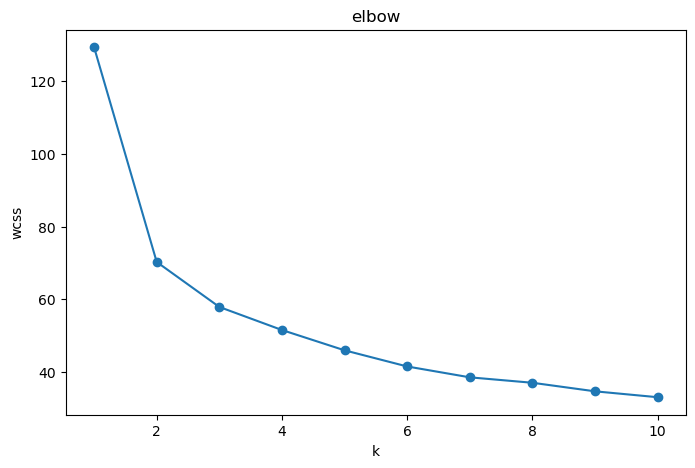

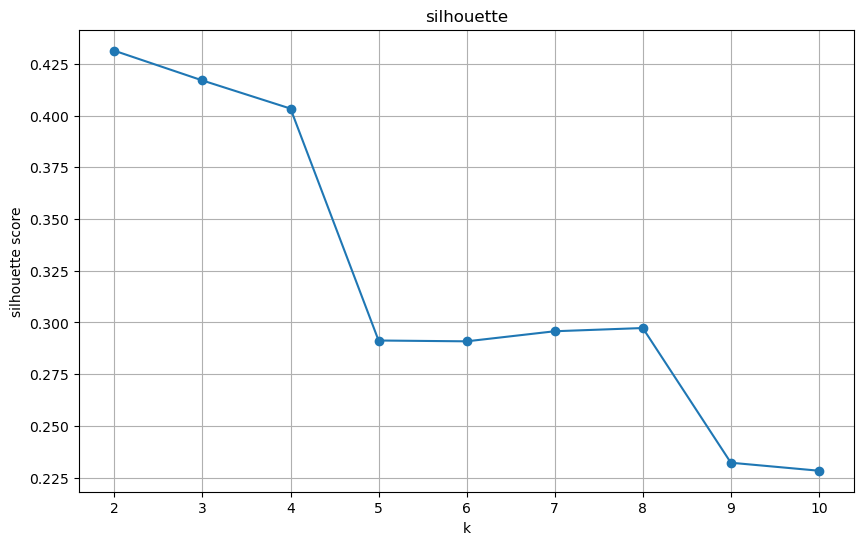

In [6]:
# elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('elbow')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('silhouette')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

In [7]:
kmeans = KMeans(n_clusters=3,         # Number of clusters
                 init='k-means++',    # Centroid initialization
                 max_iter=300,        # Maximum iterations
                 n_init=10,           # Number of initializations
                 tol=1e-4,    
                 random_state=42,    
                 algorithm='lloyd')
df_healthy['cluster'] = kmeans.fit_predict(X)
kmeans.fit(X)

labels = kmeans.predict(X)

print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[0.26479525 0.28122292 0.23433115 0.31544375 0.31176527 0.31230406
  0.31120539 0.2716166 ]
 [0.04786413 0.10322307 0.06485868 0.07342121 0.13451815 0.14390848
  0.07599987 0.04803217]
 [0.09157615 0.29008351 0.43884285 0.28409736 0.24493469 0.2121183
  0.12774786 0.17697704]]


/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_67779/3146756214.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_healthy['cluster'] = kmeans.fit_predict(X)


In [8]:
color_map = {
    "0": "red",   
    "1": "blue",   
    "2": "green",  
    # "3": "purple" 
}

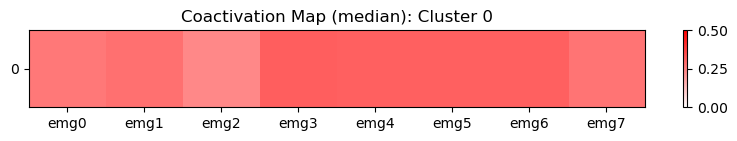

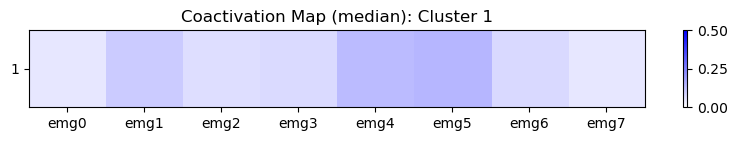

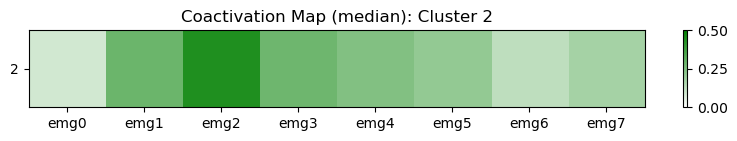

In [9]:
for i in range(len(kmeans.cluster_centers_)):
    cmap = LinearSegmentedColormap.from_list("white_to_color", ["white", color_map[str(i)]])
    cluster_center = kmeans.cluster_centers_[i]
    plot_one_class_coactivation_map(cluster_center, title='Cluster ' + str(i), label=i, cmap=cmap)

In [10]:
tsne_input = df_healthy[emgs].to_numpy()
data_tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(tsne_input)
data_tsne = pd.DataFrame(data_tsne, columns=['myx', 'myy', 'myz'])
data_tsne['cluster_ids'] = df_healthy['cluster'].to_numpy().astype(str)
data_tsne['subject_ids'] = df_healthy['subject_id'].to_numpy()


In [11]:
unique_clusters = sorted(data_tsne['cluster_ids'].unique())
# palette = px.colors.qualitative.Plotly 


# color_map = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

fig = px.scatter_3d(data_tsne,
                    x='myx', y='myy', z='myz',
                    color='cluster_ids',
                    text='subject_ids',
                    title='Relax: 3D t-SNE for K-means', 
                    color_discrete_map=color_map,
                    category_orders={'cluster_ids': unique_clusters},
                    
)
fig.update_layout(
    legend=dict(
        x=1.15,
        y=0.5, 
        xanchor='left',
        yanchor='middle' 
    )
)

fig.show()
fig.write_html('relax.html')

In [12]:
df_healthy

,date,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7,gt,hand,is_patient,n,subject_id,window,cluster
0,2023_10_16,0.032702,0.034722,0.020488,0.033537,0.094421,0.151724,0.112426,0.076923,0,left,False,11,fa,0,1
1,2023_10_16,0.125645,0.333333,0.195122,0.112805,0.154506,0.200000,0.147929,0.115385,1,left,False,11,fa,1,1
2,2023_10_16,0.049914,0.050347,0.023415,0.032012,0.090129,0.144828,0.112426,0.073077,0,left,False,11,fa,2,1
3,2023_10_16,0.327022,0.361111,0.139512,0.309451,0.278970,0.241379,0.213018,0.246154,2,left,False,11,fa,3,0
4,2023_10_16,0.032702,0.032986,0.021463,0.032012,0.090129,0.144828,0.112426,0.076923,0,left,False,11,fa,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2023_11_03,0.021898,0.043651,0.029326,0.188759,0.164430,0.205674,0.034301,0.016874,0,right,False,13,is,8,1
1552,2023_11_03,0.059437,0.347222,0.593353,0.635207,0.204698,0.262411,0.048813,0.135435,1,right,False,13,is,9,2
1553,2023_11_03,0.021898,0.043651,0.030792,0.147402,0.137584,0.226950,0.038259,0.017762,0,right,False,13,is,10,1
1554,2023_11_03,0.423879,0.351190,0.046921,0.290562,0.281879,0.304965,0.248021,0.325044,2,right,False,13,is,11,0


In [23]:
cluster_map = {0: 2, 1:0, 2:1}
list(map(cluster_map.get, df_healthy['cluster']))

[0,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,


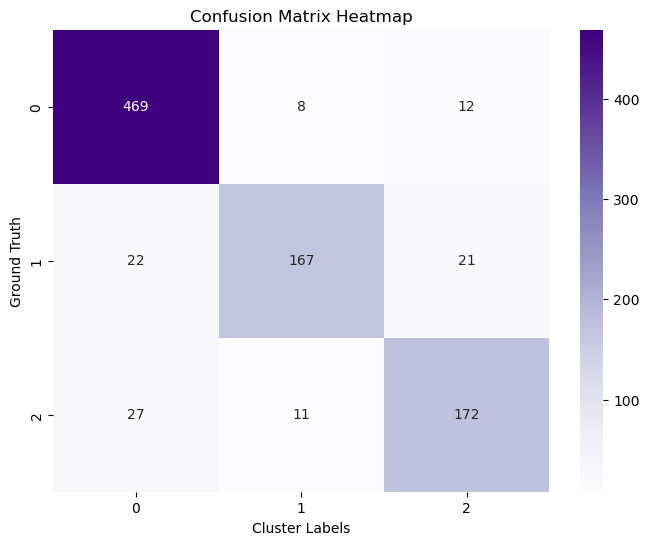

In [27]:




# gt_map = {0:'relax',1:'open',2:'close'}
# cluster_map = {0: 'close', 1:'relax', 2:'open'}
cluster_map = {0: 2, 1:0, 2:1}
conf_matrix = confusion_matrix(df_healthy['gt'], list(map(cluster_map.get, df_healthy['cluster'])))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Cluster Labels')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix Heatmap')
plt.show()

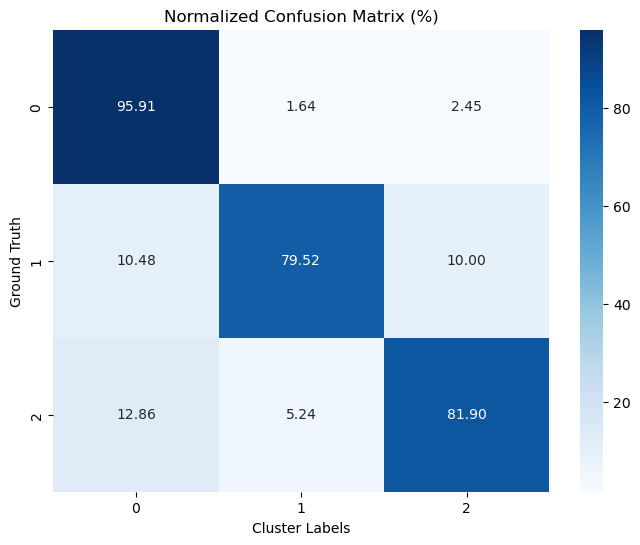

In [28]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Cluster Labels')
plt.ylabel('Ground Truth')
plt.title('Normalized Confusion Matrix (%)')
plt.show()

stroke

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_67779/3315871572.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



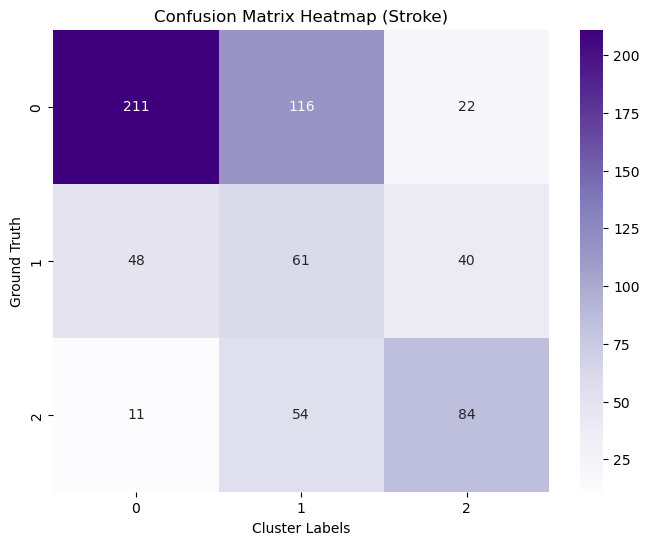

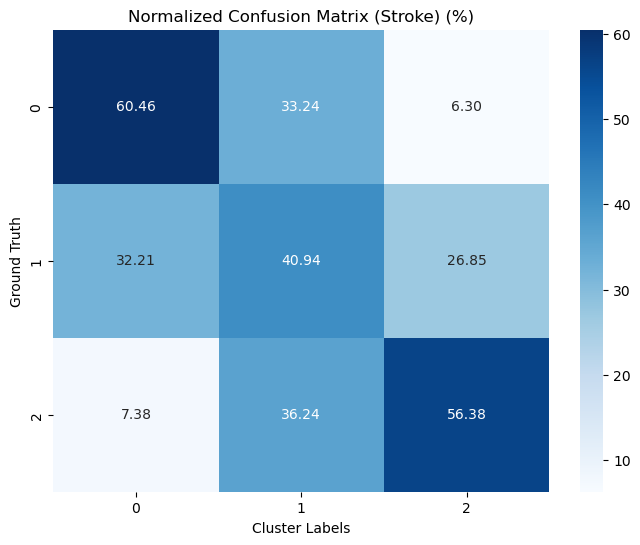

In [30]:
df_patient = df[df.is_patient==True]
df_patient['cluster'] = kmeans.fit_predict(df_patient[emgs])


conf_matrix = confusion_matrix(df_patient['gt'], list(map(cluster_map.get, df_patient['cluster'])))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Cluster Labels')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix Heatmap (Stroke)')
plt.show()

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Cluster Labels')
plt.ylabel('Ground Truth')
plt.title('Normalized Confusion Matrix (Stroke) (%)')
plt.show()

metric exploration

In [16]:
metrics = ['euclidean', 'cityblock', 'mahalanobis', 'minkowski', 'chebyshev']#, 'pearson']
results = {}
VI = np.linalg.inv(np.cov(X.T))

for metric in metrics:
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X)
    
    if metric == 'mahalanobis':
        distances = cdist(X, kmeans.cluster_centers_, metric=metric, VI=VI)
    elif metric == 'minkowski':
        p = 3
        distances = cdist(X, kmeans.cluster_centers_, metric=metric, p=p)
    elif metric == 'pearson':
        distances = np.zeros((X.shape[0], len(kmeans.cluster_centers_)))

        # Iterate over each cluster center
        for i, center in enumerate(kmeans.cluster_centers_):
            # Compute Pearson correlation with each row (data point) in X
            for j in range(X.shape[0]):
                # Pearson correlation for each data point with the center
                correlation = np.corrcoef(X[j, :], center)[0, 1]  # Compute correlation for each sample
                distances[j, i] = 1 - correlation  # Convert to distance

    else:
        distances = cdist(X, kmeans.cluster_centers_, metric=metric)
    results[metric] = silhouette_score(X, kmeans.labels_, metric=metric)

print(results)

{'euclidean': 0.4169942218230056, 'cityblock': 0.4299489860363396, 'mahalanobis': 0.2167947460440239, 'minkowski': 0.41699422182300566, 'chebyshev': 0.3671843712821104}


In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, correlation
import matplotlib.pyplot as plt
import numpy as np


true_labels = df_healthy['gt'].to_numpy()

# Initialize the results dictionary
results = {}

# Define the list of distance metrics to evaluate
metrics = ['euclidean', 'cityblock', 'mahalanobis', 'minkowski', 'chebyshev', 'pearson']


for metric in metrics:
    if metric == 'pearson':
        # Custom handling for Pearson distance metric
        # Pearson distance is 1 - Pearson correlation coefficient
        # We will use cdist to calculate this
        def pearson_distance(X, centers):
            # Pearson distance is 1 - Pearson correlation coefficient
            return cdist(X, centers, metric='correlation')

        # Fit KMeans model with custom distance for Pearson
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(X)
        distances = pearson_distance(X, kmeans.cluster_centers_)
        predicted_labels = np.argmin(distances, axis=1)
    else:
        # For other metrics, just use KMeans with the standard metric
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(X)
        predicted_labels = kmeans.labels_

    # Compute clustering evaluations
    silhouette = silhouette_score(X, predicted_labels, metric=metric if metric != 'pearson' else 'correlation')
    davies_bouldin = davies_bouldin_score(X, predicted_labels)
    inertia = kmeans.inertia_

    # Compute ARI and NMI with respect to the ground truth
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Store results for each metric
    results[metric] = {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'inertia': inertia,
        'ari': ari,
        'nmi': nmi
    }

    # # Optional: Visualize clustering (PCA for 2D projection)
    # pca = PCA(n_components=2)
    # pca_components = pca.fit_transform(X)
    # plt.figure(figsize=(8, 6))
    # plt.scatter(pca_components[:, 0], pca_components[:, 1], c=predicted_labels, cmap='viridis')
    # plt.title(f'Clustering Visualization - Metric: {metric}')
    # plt.colorbar()
    # plt.show()

# Print results for all metrics
for metric, metrics_results in results.items():
    print(f"Results for {metric} metric:")
    for score, value in metrics_results.items():
        print(f"  {score}: {value}")
    print('-' * 50)

Results for euclidean metric:
  silhouette: 0.4169942218230056
  davies_bouldin: 1.4208634571847478
  inertia: 57.90864910020274
  ari: 0.7152342254778201
  nmi: 0.5925445346479694
--------------------------------------------------
Results for cityblock metric:
  silhouette: 0.4299489860363396
  davies_bouldin: 1.4208634571847478
  inertia: 57.90864910020274
  ari: 0.7152342254778201
  nmi: 0.5925445346479694
--------------------------------------------------
Results for mahalanobis metric:
  silhouette: 0.2167947460440239
  davies_bouldin: 1.4208634571847478
  inertia: 57.90864910020274
  ari: 0.7152342254778201
  nmi: 0.5925445346479694
--------------------------------------------------
Results for minkowski metric:
  silhouette: 0.41699422182300566
  davies_bouldin: 1.4208634571847478
  inertia: 57.90864910020274
  ari: 0.7152342254778201
  nmi: 0.5925445346479694
--------------------------------------------------
Results for chebyshev metric:
  silhouette: 0.3671843712821104
  davi

In [18]:
# # X = StandardScaler().fit_transform(X)

# x_patient = df_patient[emgs].to_numpy()

# scaler = StandardScaler()
# X_healthy = scaler.fit_transform(X)  # Fit on healthy and transform healthy
# X_patient = scaler.transform(x_patient)  # Use the same scaler to transform patient data


# # Define metrics
# metrics = ['euclidean', 'cityblock',  'minkowski', 'chebyshev', 'pearson'] # 'mahalanobis',

# # Initialize the clustering result dictionary
# clustering_results = {}

# # Iterate over each metric and apply KMeans
# for metric in metrics:

#     # if metric == 'mahalanobis':
#     #     # Mahalanobis distance requires covariance matrix
#     #     cov_matrix = np.cov(X.T)
#     #     inv_cov_matrix = np.linalg.inv(cov_matrix)
#     #     dist_matrix = cdist(X, X, metric='mahalanobis', VI=inv_cov_matrix)
#     #     kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, tol=1e-4, random_state=42, algorithm='lloyd')
#     #     labels = kmeans.fit_predict(dist_matrix)
        
#     #     dist_matrix_patient = cdist(X_patient, X_healthy, metric='mahalanobis', VI=inv_cov_matrix)  # Mahalanobis distance
#     #     labels_patient = kmeans.predict(dist_matrix_patient)
        
#     if metric == 'pearson':
#         # Pearson distance (1 - correlation)
#         dist_matrix = pdist(X, metric='correlation')
#         dist_matrix = squareform(dist_matrix)
#         kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, tol=1e-4, random_state=42, algorithm='lloyd')
#         labels = kmeans.fit_predict(dist_matrix)

#         dist_matrix_patient = pdist(X_patient, metric='correlation')  
#         dist_matrix_patient = squareform(dist_matrix_patient)  
#         labels_patient = kmeans.predict(dist_matrix_patient) 

#     else:
#         # For other metrics, use KMeans directly
#         kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, tol=1e-4, random_state=42, algorithm='lloyd')
#         labels = kmeans.fit_predict(X)

#         labels_patient = kmeans.predict(X_patient)

#     # Store the labels in the clustering_results dictionary
#     df_healthy[f'cluster_{metric}'] = labels
#     df_patient[f'cluster_{metric}'] = labels_patient
#     clustering_results[metric] = kmeans

# # Print the cluster centers for each metric
# for metric, kmeans in clustering_results.items():
#     print(f"\nCluster Centers for {metric} distance:")
#     print(kmeans.cluster_centers_)

#     conf_matrix = confusion_matrix(df_healthy['gt'], df_healthy[f'cluster_{metric}'])
#     conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
#     plt.xlabel('Cluster Labels')
#     plt.ylabel('Ground Truth')
#     plt.title('Normalized Confusion Matrix (Healthy) (%)')
#     plt.show()

#     # conf_matrix = confusion_matrix(df_patient['gt'], df_patient[f'cluster_{metric}'])
#     # conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
#     # plt.figure(figsize=(8, 6))
#     # sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
#     # plt.xlabel('Cluster Labels')
#     # plt.ylabel('Ground Truth')
#     # plt.title('Normalized Confusion Matrix (Stroke) (%)')
#     # plt.show()

In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_healthy is your DataFrame for healthy data and df_patient for patient data
# Replace with actual column names for features
X_healthy = df_healthy[emgs].to_numpy()  # Adjust the features you're using
X_patient = df_patient[emgs].to_numpy()  # Same features for patient data

# Standardize both datasets (important for most distance metrics)
scaler = StandardScaler()
X_healthy_scaled = scaler.fit_transform(X_healthy)  # Fit on healthy and transform healthy
X_patient_scaled = scaler.transform(X_patient)  # Use the same scaler to transform patient data

from sklearn.cluster import KMeans
# from sklearn_extra.cluster import KMeans as KMeansExtra
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define distance metrics you want to try
distance_metrics = ['euclidean', 'manhattan', 'cosine', 'precomputed']  # Example metrics

# Iterate over each distance metric
for metric in distance_metrics:
    # Initialize KMeans with the current distance metric
    kmeans = KMeans(n_clusters=3,         # Number of clusters
                         init='k-means++',    # Centroid initialization
                         max_iter=300,        # Maximum iterations
                         n_init=10,           # Number of initializations
                         tol=1e-4,    
                         random_state=42,    
                         algorithm='lloyd', 
                         metric=metric)  # Set custom distance metric

    # Perform the clustering
    df_healthy['cluster'] = kmeans.fit_predict(X)

    # Predict the cluster labels
    labels = kmeans.predict(X)

    # Output the cluster centers and metric used
    print(f"Using {metric} distance metric:")
    print("Cluster Centers:\n", kmeans.cluster_centers_)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(df_healthy['gt'], df_healthy['cluster'])

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Plot the normalized confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Cluster Labels')
    plt.ylabel('Ground Truth')
    plt.title(f'Normalized Confusion Matrix (%) - Metric: {metric}')
    plt.show()



TypeError: KMeans.__init__() got an unexpected keyword argument 'metric'

# explore 200  hz data

(0.0, 2.0)

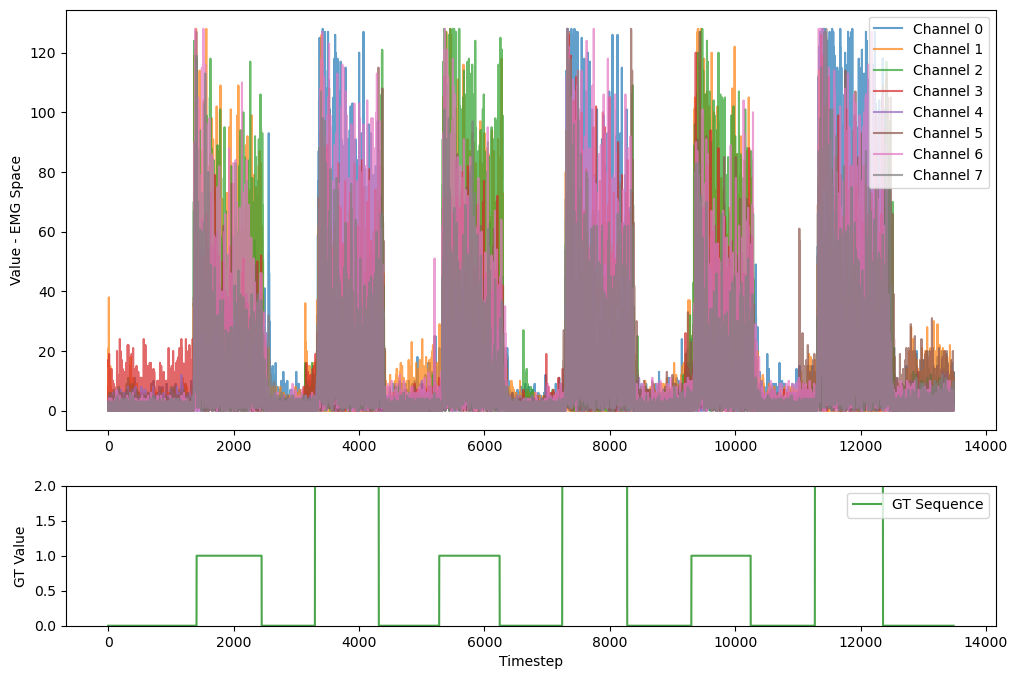

In [10]:
df200 = pd.read_csv('data_200hz/runsheng_new_200hz.csv')
df200 = np.abs(df200)

# Adjust figure size and use gridspec for uneven subplot heights
fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
# EMG Signals 
gt_sequence = df200['gt']
df200_emgs = df200[emgs]
for channel in range(8):
    axs[0].plot(df200_emgs[emgs[channel]], label=f'Channel {channel}', alpha=0.7)
axs[0].set_ylabel('Value - EMG Space')
axs[0].legend(loc='upper right')
# GT Sequence
axs[1].plot(gt_sequence, label='GT Sequence', color='green', alpha=0.7)
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('GT Value')
axs[1].legend(loc='upper right')
axs[1].set_ylim(0, 2)

emg,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7
gt,,,,,,,,
0,0.015625,0.023438,0.015625,0.015873,0.025641,0.015625,0.007812,0.007812
1,0.078125,0.187500,0.218750,0.095238,0.089744,0.093750,0.117188,0.070312
2,0.265625,0.015625,0.093750,0.119048,0.115385,0.101562,0.195312,0.125000


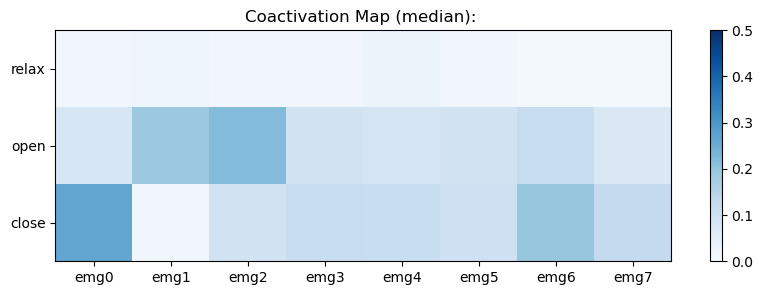

In [8]:
df200_preprocessed = preprocess_emgs('data_200hz/runsheng_new_200hz.csv', 200)
display(get_coactivation_map(df200_preprocessed))
plot_coactivation_map(get_coactivation_map(df200_preprocessed))

(0.0, 2.0)

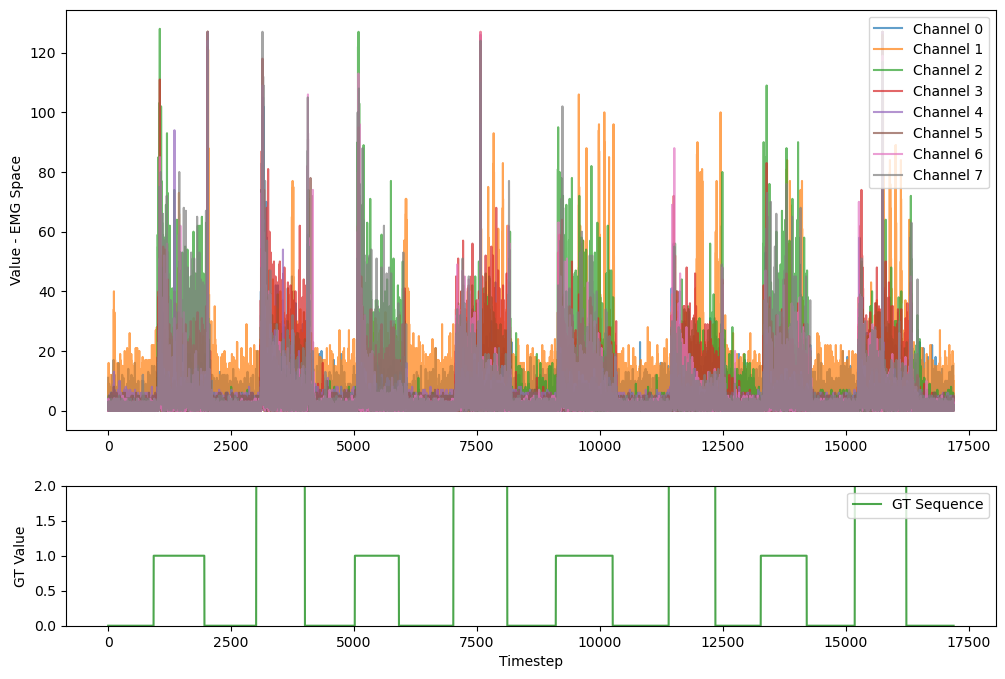

In [11]:
df200 = pd.read_csv('data_200hz/yolanda_new_200hz.csv')
df200 = np.abs(df200)

# Adjust figure size and use gridspec for uneven subplot heights
fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
# EMG Signals 
gt_sequence = df200['gt']
df200_emgs = df200[emgs]
for channel in range(8):
    axs[0].plot(df200_emgs[emgs[channel]], label=f'Channel {channel}', alpha=0.7)
axs[0].set_ylabel('Value - EMG Space')
axs[0].legend(loc='upper right')
# GT Sequence
axs[1].plot(gt_sequence, label='GT Sequence', color='green', alpha=0.7)
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('GT Value')
axs[1].legend(loc='upper right')
axs[1].set_ylim(0, 2)

emg,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7
gt,,,,,,,,
0,0.015748,0.047244,0.015625,0.007874,0.015748,0.007937,0.007874,0.007874
1,0.031496,0.055118,0.085938,0.047244,0.015748,0.015873,0.023622,0.047244
2,0.047244,0.062992,0.054688,0.062992,0.023622,0.023810,0.031496,0.039370


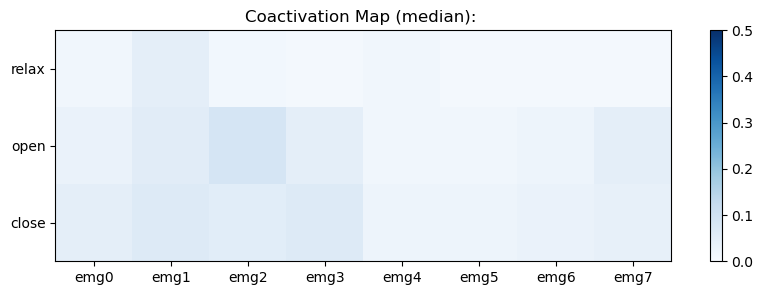

In [12]:
df200_preprocessed = preprocess_emgs('data_200hz/yolanda_new_200hz.csv', 200)
display(get_coactivation_map(df200_preprocessed))
plot_coactivation_map(get_coactivation_map(df200_preprocessed))